# Classification

There are several models which could be used for classification but in this project we will limit ourselve to the Gaussian Mixture model since the distribution of polymer chains produced at a site follows a gaussian distribution. 

In [1]:
# importing the required modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture 
from scipy.optimize import curve_fit

In [2]:
#importing required files
%matplotlib inline

plt.style.use('fivethirtyeight')

#loading our file
fname ='../data/interim/chain_distribution.csv'
chains_distribution = pd.read_csv(fname)
chains_distribution.head()
chains_orig = pd.read_csv('../data/raw/Dataset.csv')

In [3]:
# classification function
def classification_func(distribution,n_comps):
    """Identify subpopulations
    Args:
        distributions(df): columns =[chain_length,weight_fraction]
        n_comps(int): the number of clusters to identify
    returns: 
        list: [weight, mean,standard deviation] of each cluster 
    """
    # creating a model and fitting the model to the data
    gmm =GaussianMixture(n_components=n_comps, covariance_type='full').fit(distribution) 
    mean = gmm.means_[:,0] # the first columns contains the means   
    #covariance returns a set of arrays each for one cluster. The main diagonal contains the variance
    covariance = gmm.covariances_    
    # the weights here are the population fractions
    weight = gmm.weights_
    
    cluster_parms =[] # to store the cluster parameters
    for i in range(n_comps):
        cluster_parms.append([weight[i],mean[i],np.sqrt(np.diag(covariance[i]))[0]])
    return list(np.hstack(cluster_parms))

In [4]:
# writing the gaussian function to be used to plot  parameters obtained from classification
def gaussian_func(x,*params):
    """ generate the gaussian distribution"""
    # the optimization routine returns an array instead of a list
    if type(params[0])==np.ndarray:
        params = np.concatenate(params).tolist()
    y = np.zeros_like(x)
    if type(params) == tuple:
        params = list(params)
    for i in range(0,len(params),3):
        amp= params[i] # amplitude
        ctr = params[i+1] # peak location
        wid = params[i+2] # standard deviation
        y += amp*np.exp(-((x-ctr)/wid)**2)
    return y

The following steps would be taken:
* Classification of chains into subpopulation
* Determination of subpopulation characteristics 
* making use of the subpopulation characteristics as initial guess for the various distributions
* Optimizing those initial guesses 
* Evaluation of the goodness of fit


In [5]:
def optimization_routine(rawdata, gmm_parameters,gaussFunct):
    """Optimize parameters obtained from the Classification model
    Args:
        rawData(df): raw data
        gmm_parameters[list]: list of init parameters obtained from gmm
        gaussFunct(functions): gaussian functions to be used to perform curve optimization
    returns:
        array: [amp, peak location, width]
    """
    x_raw = rawdata.iloc[:,0].dropna().values;y_raw=rawdata.iloc[:,1].dropna().values
    
    # returns the fitting parameters, accepts the function,data and init_para
    popt_gauss, pcov_gauss = curve_fit(gaussFunct, x_raw, y_raw, p0=gmm_parameters, maxfev = 50000)
    
    optimizedParameter = np.asarray(popt_gauss).reshape(-1,3)
    return sorted(optimizedParameter, key= lambda x: x[1])
                            

Though pcov returned from curve_fit is a measure of the error, we will instead use the difference in the area under the curve for our evaluation. It is a much better option in this case for 2 reasons:
1. since the number of clusters increases at each iteration, the sum of the errors will scale up with the number of clusters. Though we can deal with that through some form of normalization, it just add an extra layer of incovenience.
2. secondly if the classification is done correctly, we will have to be able to regenerate the original curve. For that reason the difference in area under the curves will be used. 

In [6]:
# checking the error
ls = []
ns = []
clusters = []
for n in range(1,6):
    clusters_param = classification_func(chains_distribution,n_comps=n)
    optimized_parms = optimization_routine(chains_distribution, clusters_param,gaussian_func)
    clusters.append(optimized_parms)
    area_org = np.trapz(x=chains_orig.iloc[:,0],y=chains_orig.iloc[:,1])
    area_gen = np.trapz(x=chains_orig.iloc[:,0],y=gaussian_func(chains_orig.iloc[:,0],*optimized_parms))
    error = abs(area_org-area_gen)
    ns.append(n)
    ls.append(error)

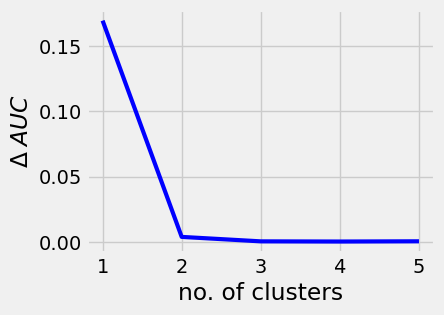

In [7]:
# observing the errors
fig = plt.figure(figsize=(4,3))
plt.plot(ns,ls,'b-',lw=3)
plt.xlabel('no. of clusters')
plt.ylabel('$\Delta \; AUC$')
plt.show()

Now observing the outputs

In [8]:
def single_gauss(x,params):
    """" Generates a single Gaussian curve
    Args:
        x(array): chain lenghts
        params(list): [amp,mean,std]
    returns:
        y(array): the Gaussian curve"""
    
    amp,ctr,wid= params[0],params[1],params[2] 
    return amp*np.exp(-((x-ctr)/wid)**2)
    
def plot_distro(orig_data,params):
    for i in range(len(params)):
        plt.plot(orig_data.iloc[:,0],single_guass(orig_data.iloc[:,0],*clusters[2]),lw=3)

    plt.xlabel('$Log \; M$')
    plt.ylabel('$dw/dLogM$')
    plt.title('Figure 4')
    plt.show()
    return None

In [9]:
curve_dic ={}
#Storrng the distributions
n =1
for cluster in clusters:
    dist = []
    dist.append(chains_orig.iloc[:,0])
    for curve in cluster:
        dist.append(single_gauss(chains_orig.iloc[:,0],curve))
    curve_dic[n] = dist
    n+=1

In [10]:

for key,val in curve_dic.items():
    # stacking the curves and storing them to a dataframe
    cols = [f'curve{i}' for i in range(1,len(val)-1)]
    cols = ['chain_length','original_distribution'] + cols
    df = pd.DataFrame(np.asarray(val).T)
    df.columns = cols
    df.head(n=2)



Text(0, 0.5, '$dw/dLogM$')

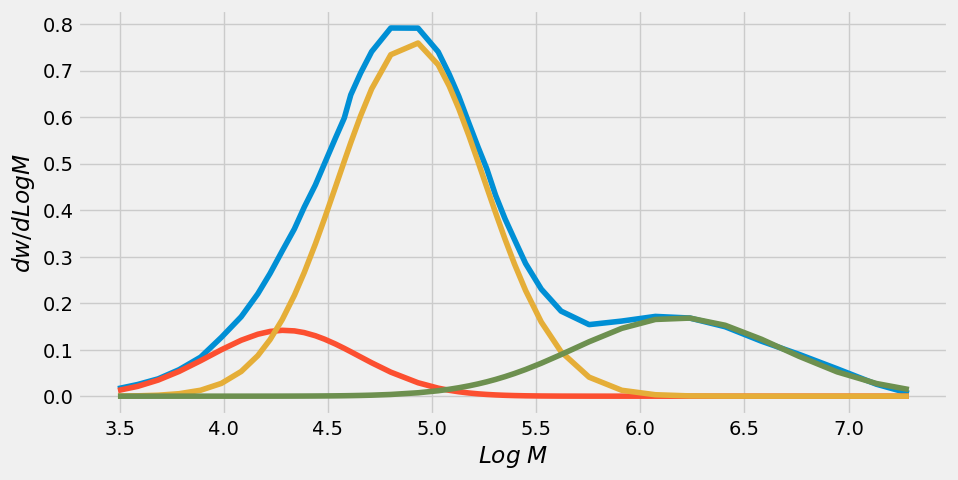

In [12]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.plot(chains_orig.iloc[:,0],chains_orig.iloc[:,1])
for i in range(len(clusters[2])):
    curve = clusters[2][i]
    
    plt.plot(chains_orig.iloc[:,0],single_gauss(chains_orig.iloc[:,0],curve))

plt.xlabel('$Log \; M$')
plt.ylabel('$dw/dLogM$')


    


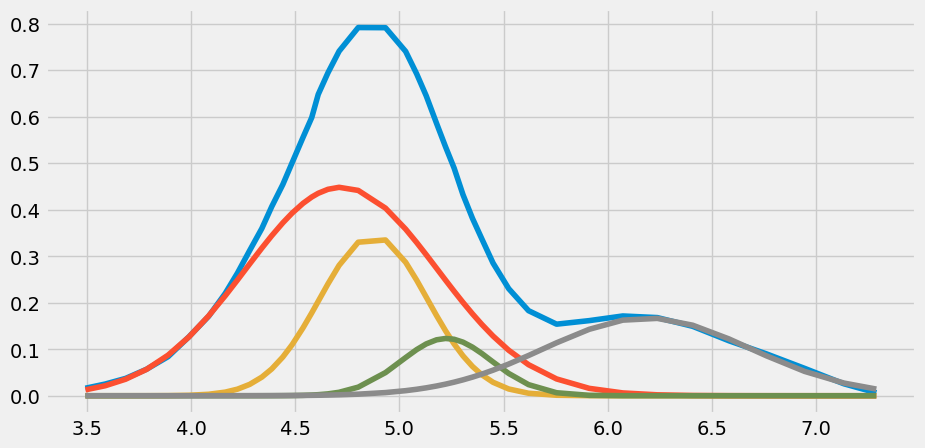

In [13]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.plot(chains_orig.iloc[:,0],chains_orig.iloc[:,1])
for i in range(0,len(clusters[3])):
    curve = clusters[3][i]
    
    plt.plot(chains_orig.iloc[:,0],single_gauss(chains_orig.iloc[:,0],curve))

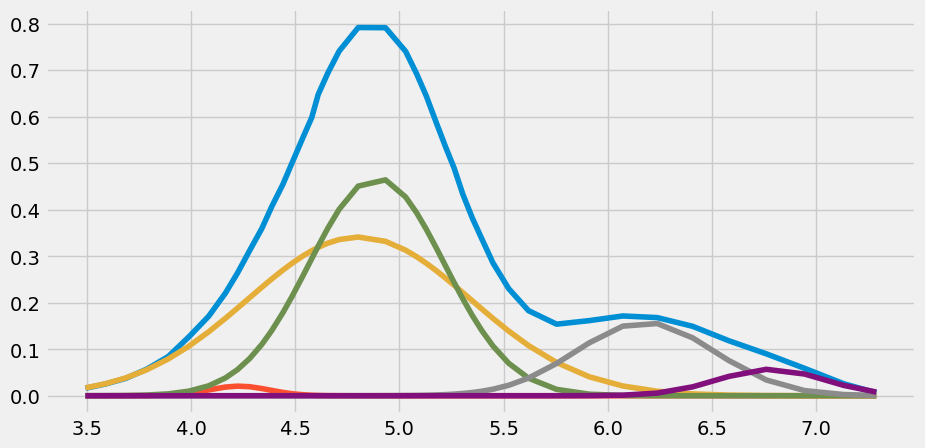

In [14]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.plot(chains_orig.iloc[:,0],chains_orig.iloc[:,1])
for i in range(0,len(clusters[4])):
    curve = clusters[4][i]
    
    plt.plot(chains_orig.iloc[:,0],single_gauss(chains_orig.iloc[:,0],curve))

IndexError: list index out of range

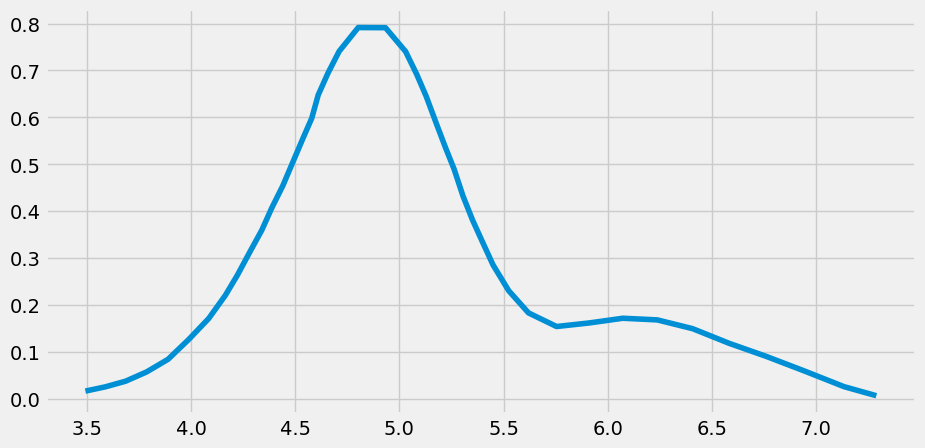

In [15]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.plot(chains_orig.iloc[:,0],chains_orig.iloc[:,1])
for i in range(0,len(clusters[1]),3):
    curve = clusters[1][i:i+3]
    plt.plot(chains_orig.iloc[:,0],single_gauss(chains_orig.iloc[:,0],curve))